In [2]:
#Data handling
import h5py
#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import sys


#Mathematical libraries
import numpy as np
import pandas as pd

import pickle
import subprocess
import itertools

In [3]:
data = pd.read_csv('cath-b-newest-all.txt', sep=" ", header=None)
data.columns = ["pdb_chain_domain", "version", "cath", "residues"]

In [4]:
data

pdb_chain_domain   version         cath  \
0               101mA00    v4_2_0  1.10.490.10   
1               102lA00    v4_2_0  1.10.530.40   
2               102mA00    v4_2_0  1.10.490.10   
3               103lA00    v4_2_0  1.10.530.40   
4               103mA00    v4_2_0  1.10.490.10   
...                 ...       ...          ...   
527903          7bwgA02  putative   3.20.20.80   
527904          7bwgB02  putative   3.20.20.80   
527905          7bwpA01  putative   3.50.50.60   
527906          7bwpA02  putative  3.30.410.40   
527907          7byzA00  putative  1.10.640.10   

                                     residues  
0                                     0-153:A  
1                                     1-162:A  
2                                     0-153:A  
3                                     1-162:A  
4                                     0-153:A  
...                                       ...  
527903                              138-478:A  
527904                              138-478:B  
527905  9-146:A,192-298:A,368-390:A,458-519:A  
527906          147-191:A,299-367:A,391-457:A  
527907                                1-595:A  

[527908 rows x 4 columns]

In [5]:
df = pd.read_hdf('/data/lohia/EGAD_analysis/3d_pred/gene3dout.hdf5', 'nw') #this was the file written from api
df = pd.concat([df.drop(['metadata'], axis=1), df['metadata'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop(['evidences'], axis=1), df['evidences'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop(['source'], axis=1), df['source'].apply(pd.Series)], axis=1)
df = df.loc[df['type'] == 'PREDICTED_DOMAIN']
df_cath_prediction = df[df['resource'].isin(['pDomTHREADER'])]
df_cath_prediction['loc_length'] = [i[0]['fragments'][0]['end'] - i[0]['fragments'][0]['start'] + 1 for i in df_cath_prediction['locations']]
#df_cath_prediction = df[df['resource'].isin(['FUGUE (CATH-based)', 'Gene3D', 'pDomTHREADER'])]
df_cath_prediction.drop(columns=['length', 'tooltipContent', 'anno_id', 'type', 'code', 'name', 'url'], inplace=True)
df_cath_prediction['confidence'] = df_cath_prediction['confidence'].astype('int')
df_cath_prediction = df_cath_prediction[(df_cath_prediction['confidence'] > 95) & (df_cath_prediction['loc_length'] > 30)]

/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/lohia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [6]:
#This merge is to limit domains whose residue informtion is present in cath file
merged_left = pd.merge(left=df_cath_prediction, right=data, how='left', left_on='id', right_on='pdb_chain_domain')
merged_left.dropna(inplace=True)

In [6]:
#for now I won't be doing this step
#idx = merged_left.groupby(['accession'])['loc_length'].transform(max) == merged_left['loc_length'] #represents each protein with maximum length id
#merged_left = merged_left[idx]

In [7]:
merged_left['pdb'] = merged_left['pdb_chain_domain'].str[:4] # removing extra characters in protein name
merged_left['chain'] = merged_left['pdb_chain_domain'].str[4:5]
merged_left['pdb_chain'] = merged_left['pdb'] + '_' + merged_left['chain']

In [8]:
accession_domid = merged_left.groupby(['accession']).agg({'pdb_chain_domain': lambda x: list(x)})

In [9]:
accession_domid

pdb_chain_domain
accession                                      
A0AV96                       [1n54B00, 1x5uA01]
A0AVF1                       [1na0A00, 1hz4A00]
A0AVI2     [2nsqA00, 2uzpA00, 1yrkA00, 1rsyA00]
A0AVK6                       [1cf7A00, 1s58A00]
A0FGR8              [1rlwA00, 1yrkA00, 2bwqA00]
...                                         ...
Q9Y6X9                                [1b63A01]
Q9Y6Y0                       [1cs3A00, 1zgkA00]
Q9Y6Y1              [1s58A00, 3bmvA03, 1n11A00]
Q9Y6Y8                       [1s58A00, 1dxsA00]
Q9Y6Y9                                [1nepA00]

[6533 rows x 1 columns]

In [30]:
#the generated file is used to run vmd locally, I downlaod all the pdb domain required
with open('domain_id.txt', 'wb') as fp:
    pickle.dump(list(set(merged_left['pdb_chain_domain'].tolist())), fp)

#after this step all the generated pdb files are synced back to rugen12 from my local machine

In [10]:
exp = pd.read_hdf('/data/lohia/EGAD_analysis/3d_pred/filtered_exp.hdf5', 'nw') #this was the file written from api
subset_cols = list (set(exp.index) & set(merged_left.accession))
exp = exp.loc[subset_cols, subset_cols]

long_form = exp.unstack()
long_form.index.rename(['col_1', 'col_2'], inplace=True)
long_form = long_form.to_frame('exp').reset_index()

In [11]:
exp

Q8NHU2    Q14566    Q4ADV7    Q3BBV0    Q9UQC9    Q05513    P30533  \
Q8NHU2  0.999932  0.279989  0.428549  0.525182  0.172168  0.244819  0.344395   
Q14566  0.279989  0.999932  0.936208  0.801739  0.152571  0.629548  0.878646   
Q4ADV7  0.428549  0.936208  0.999932  0.845853  0.256649  0.589040  0.861904   
Q3BBV0  0.525182  0.801739  0.845853  0.999932  0.253692  0.735937  0.741373   
Q9UQC9  0.172168  0.152571  0.256649  0.253692  0.999932  0.109908  0.173325   
...          ...       ...       ...       ...       ...       ...       ...   
O60716  0.297908  0.912411  0.969814  0.873685  0.227891  0.660522  0.911853   
Q96LT9  0.464433  0.689202  0.897306  0.919373  0.207189  0.677591  0.555603   
Q9UPW8  0.261859  0.330507  0.336187  0.340897  0.033598  0.393716  0.238041   
O43150  0.367303  0.722979  0.865117  0.799015  0.250516  0.559968  0.738029   
Q96KN2  0.103209  0.197532  0.324933  0.268579  0.158977  0.245874  0.228880   

          Q14CX7    Q8IVL8    P46087  ...    Q04727    Q96K80    Q9HAP6  \
Q8NHU2  0.400590  0.374050  0.227245  ...  0.377250  0.560237  0.392725   
Q14566  0.936250  0.111745  0.648193  ...  0.759507  0.877221  0.629349   
Q4ADV7  0.956670  0.335108  0.696413  ...  0.968810  0.916894  0.511041   
Q3BBV0  0.886848  0.370238  0.656084  ...  0.811460  0.870528  0.689165   
Q9UQC9  0.292251  0.129477  0.077565  ...  0.249648  0.186923  0.053683   
...          ...       ...       ...  ...       ...       ...       ...   
O60716  0.902486  0.359063  0.602527  ...  0.864556  0.844564  0.688081   
Q96LT9  0.919511  0.434777  0.660280  ...  0.852658  0.877109  0.587628   
Q9UPW8  0.444033  0.187622  0.191358  ...  0.251911  0.470405  0.399570   
O43150  0.796951  0.210927  0.521120  ...  0.786265  0.761691  0.345447   
Q96KN2  0.441972  0.343025  0.365028  ...  0.294776  0.386903  0.223131   

          P51649    Q8WXI9    O60716    Q96LT9    Q9UPW8    O43150    Q96KN2  
Q8NHU2  0.526732  0.307158  0.297908  0.464433  0.261859  0.367303  0.103209  
Q14566  0.768440  0.552264  0.912411  0.689202  0.330507  0.722979  0.197532  
Q4ADV7  0.764679  0.805599  0.969814  0.897306  0.336187  0.865117  0.324933  
Q3BBV0  0.875194  0.702887  0.873685  0.919373  0.340897  0.799015  0.268579  
Q9UQC9  0.166769  0.047463  0.227891  0.207189  0.033598  0.250516  0.158977  
...          ...       ...       ...       ...       ...       ...       ...  
O60716  0.749469  0.620659  0.999932  0.773110  0.279679  0.909132  0.250056  
Q96LT9  0.850126  0.855306  0.773110  0.999932  0.258565  0.721355  0.305473  
Q9UPW8  0.382480  0.343890  0.279679  0.258565  0.999932  0.262065  0.219545  
O43150  0.629147  0.655948  0.909132  0.721355  0.262065  0.999932  0.077424  
Q96KN2  0.248424  0.143409  0.250056  0.305473  0.219545  0.077424  0.999932  

[6187 rows x 6187 columns]

In [12]:
accession_domid = accession_domid.loc[subset_cols, :]

In [16]:
#uni_pdb = dict(zip(merged_left.accession,merged_left.pdb))
#uni_pdbdomain = dict(zip(merged_left.accession,merged_left.pdb_chain_domain))
unip_pdbdomain = dict(zip(accession_domid.index,accession_domid.pdb_chain_domain)) #this is a tupled list of uniprot id and domain_id
#print (uni_pdbdomain.values())
#uni_pdbdomain = list(zip(merged_left.accession,merged_left.pdb_chain_domain)) #this is a tupled list of uniprot id and domain_id

#print (uni_pdbdomain)
#uni_pdb_chain =  dict(zip(merged_left.accession,merged_left.pdb_chain))

#new=merged_left['cath'].str.split(".", n = 3, expand = True)  # expand the cath domains
#merged_left['cat'] = new[0] + '.' + new[1] + '.' + new[2]
#merged_left_uniq_domain = merged_left.drop_duplicates(subset=['pdb_chain_domain'])

#domain_cath =  dict(zip(merged_left_uniq_domain.pdb_chain_domain,merged_left_uniq_domain.cat))

#uni_id = list(set(list(exp.index.values)))

#domain_uniq= [uni_pdbdomain[y] for y in uni_id]
#domain_uniq = ([x[1] for x in uni_pdbdomain if x[0] in uni_id]) #filtering only the list present in my exp table
unip_pairs = list(itertools.combinations(unip_pdbdomain.values(),2)) #this gets all the unique combination of lists


In [17]:
dom_pairs = [sorted(list(itertools.product(x[0], x[1]))) for x in unip_pairs]

In [18]:
dom_pairs_com = [item for sub_list in dom_pairs for item in sub_list]

In [19]:
dom_pairs_sorted =  [tuple(sorted(x)) for x in dom_pairs_com]

In [20]:
dom_pairs_uni = list(set(dom_pairs_sorted))

In [21]:
len(dom_pairs_uni)

4629614

In [27]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
list_chunks = list(chunks(dom_pairs_uni, 180000))

In [28]:
len(list_chunks)

26

In [29]:
#writes the list chunks into file for running from terminal
for counter, given_list in enumerate(list_chunks):
    with open('/data/lohia/EGAD_analysis/egad_cath/dom_pairs_uni_%s.txt' %counter, 'wb') as fp:
        pickle.dump(given_list, fp)

In [ ]:
#run from terminal ( for i in {0..26}; do python tm_score_domain.py $i >& $i.out &  done)

index_list = pickle.load( open( '/data/lohia/EGAD_analysis/egad_cath/dom_pairs_uni_%s.txt' %sys.argv[1], "rb" ) )
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
list_chunks = list(chunks(index_list, 1000))

#run from terminal
result = []
for given_list in list_chunks:
    domain_pair_tm_score = [subprocess.check_output("/data/lohia/TMalign /data/lohia/EGAD_analysis/egad_cath/pdb_files_chain_residues/%s.pdb /data/lohia/EGAD_analysis/egad_cath/pdb_files_chain_residues/%s.pdb -a | grep 'TM-score=' | awk 'FNR == 3 {print $2}'" %(dom[0], dom[1]), shell=True).strip().decode('ascii') for dom in given_list]
    new_items = [np.nan if x=='' else float(x) for x in domain_pair_tm_score]
    score_df = pd.DataFrame(given_list, columns =["id1", "id2"]) 
    score_df["tmscore"] = new_items
    result.append(score_df)
prot_list = pd.concat(result)
prot_list.to_hdf('/data/lohia/EGAD_analysis/egad_cath/dompair_tmscores/dompair_tmscores_%s.h5' %sys.argv[1], key='df', mode='w')

In [31]:
for counter, given_list in enumerate(list_chunks):
    domain_pair_tm_score = [subprocess.check_output("/data/lohia/TMalign /data/lohia/EGAD_analysis/egad_cath/pdb_files_chain_residues/%s.pdb /data/lohia/EGAD_analysis/egad_cath/pdb_files_chain_residues/%s.pdb -a | grep 'TM-score=' | awk 'FNR == 3 {print $2}'" %(dom[0], dom[1]), shell=True).strip().decode('ascii') for dom in given_list]
    #domain_pair_tm_score = [subprocess.check_output("/data/lohia/EGAD_analysis/egad_cath/pdb_files_chain/%s.pdb /data/lohia/EGAD_analysis/egad_cath/pdb_files_chain/%s.pdb -a | grep 'TM-score=' | awk 'FNR == 3 {print $2}'" %(dom[0], dom[1]), shell=True).strip().decode('ascii') for dom in given_list]    domain_pair_tm_score = [subprocess.check_output("/data/lohia/TMalign /data/lohia/EGAD_analysis/pdb_files/pdb_files/%s_%s.pdb /data/lohia/EGAD_analysis/egad_cath/pdb_files_chain_residues/%s_%s.pdb -a | grep 'TM-score=' | awk 'FNR == 3 {print $2}'" %(dom[0].str[:4], dom[0].str[4:5], dom[1].str[:4], dom[1].str[4:5]), shell=True).strip().decode('ascii') for dom in given_list]
    new_items = [np.nan if x=='' else float(x) for x in domain_pair_tm_score]
    score_df = pd.DataFrame(given_list, columns =["id1", "id2"]) 
    score_df["tmscore"] = new_items
    score_df.to_hdf('/data/lohia/EGAD_analysis/egad_cath/dompair_tmscores/dompair_tmscores_%s.h5' %counter, key='df', mode='w')

KeyboardInterrupt: 

In [16]:
#this calcuates dictionary of domain pairs with its scores
result = []
#for i in range(0,len(list_chunks)):
for i in range(0,26):
    score_df = pd.read_hdf('/data/lohia/EGAD_analysis/egad_cath/dompair_tmscores/dompair_tmscores_%s.h5' %i)
    result.append(score_df)
df_domain_pair_tm_score = pd.concat(result) 
#print (df_domain_pair_tm_score)

In [17]:
id1 = df_domain_pair_tm_score["id1"].tolist()
id2 = df_domain_pair_tm_score["id2"].tolist()
tmscore = df_domain_pair_tm_score["tmscore"].tolist()
df_domain_pair_tm_score_rev = pd.DataFrame({"id1": id2, "id2": id1, "tmscore": tmscore })

In [15]:
#this is done to ensure the overpopulated viral capsid protein is no longer identified as a domain
df_domain_pair_tm_score_rev["tmscore"] = [np.nan if x== '1s58A00' else np.nan if y== '1s58A00' else z for x, y, z in zip(df_domain_pair_tm_score_rev["id1"], df_domain_pair_tm_score_rev["id1"], df_domain_pair_tm_score_rev["tmscore"])]

In [18]:
df_domain_pair_tm_score_identity = pd.DataFrame({"id1": accession_domid.index.tolist(), "id2": accession_domid.index.tolist(), "tmscore": 1 })
df_domain_pair = pd.concat([df_domain_pair_tm_score, df_domain_pair_tm_score_rev, df_domain_pair_tm_score_identity], ignore_index=True)

df_domain_pair['pair'] = df_domain_pair['id1'] + '_' + df_domain_pair['id2']
domainpair_score =  dict(zip(df_domain_pair.pair,df_domain_pair.tmscore))
#dict_items = domainpair_score.items()
#print (list(dict_items)[:2])
#tm_score_domain = [ domainpair_score[uni_pdbdomain[uni_1] + '_' + uni_pdbdomain[uni_2]] for uni_1, uni_2 in zip(long_form['col_1'], long_form['col_2'])]

In [19]:
long_form_dom_1 = pd.merge(left=long_form, right=accession_domid, how='left', left_on='col_1', right_on='accession')

long_form_dom_2 = pd.merge(left=long_form_dom_1, right=accession_domid, how='left', left_on='col_2', right_on='accession')

long_form_dom_2['dom_pairs'] = [sorted(list(itertools.product(x, y))) for x, y in zip(long_form_dom_2['pdb_chain_domain_x'], long_form_dom_2['pdb_chain_domain_y'])]

long_form_dom_2['dom_pair_scores']  = [list(map(lambda x: domainpair_score[x[0] + '_' + x[1]] if (x[0] + '_' + x[1]) in domainpair_score.keys() else np.nan , row_pair)) for row_pair in long_form_dom_2['dom_pairs']]

In [20]:
long_form_dom_2[long_form_dom_2['col_1']=='Q96E11']

col_1   col_2       exp pdb_chain_domain_x  \
17038998  Q96E11  Q8NHU2  0.439857          [1wqgA01]   
17038999  Q96E11  Q14566  0.966852          [1wqgA01]   
17039000  Q96E11  Q4ADV7  0.934284          [1wqgA01]   
17039001  Q96E11  Q3BBV0  0.896915          [1wqgA01]   
17039002  Q96E11  Q9UQC9  0.284308          [1wqgA01]   
...          ...     ...       ...                ...   
17045180  Q96E11  O60716  0.945557          [1wqgA01]   
17045181  Q96E11  Q96LT9  0.900215          [1wqgA01]   
17045182  Q96E11  Q9UPW8  0.406363          [1wqgA01]   
17045183  Q96E11  O43150  0.762216          [1wqgA01]   
17045184  Q96E11  Q96KN2  0.339051          [1wqgA01]   

                                     pdb_chain_domain_y  \
17038998                             [1fcdA01, 2gqwA01]   
17038999                    [1ltlA01, 1ltlA02, 1g8pA01]   
17039000                             [1pguB02, 1gxrA00]   
17039001                                      [1up8A00]   
17039002                             [1atzB00, 1ri6A00]   
...                                                 ...   
17045180                             [1s58A00, 1jdhA00]   
17045181                             [2errA01, 1oiaB00]   
17045182  [1s58A00, 1ptqA00, 2nsqA00, 2vglA00, 2uzpA00]   
17045183  [1i4dA00, 2dhjA00, 1n0qB00, 1jvrA00, 2ak5B00]   
17045184                                      [2pokA01]   

                                                  dom_pairs  \
17038998           [(1wqgA01, 1fcdA01), (1wqgA01, 2gqwA01)]   
17038999  [(1wqgA01, 1g8pA01), (1wqgA01, 1ltlA01), (1wqg...   
17039000           [(1wqgA01, 1gxrA00), (1wqgA01, 1pguB02)]   
17039001                               [(1wqgA01, 1up8A00)]   
17039002           [(1wqgA01, 1atzB00), (1wqgA01, 1ri6A00)]   
...                                                     ...   
17045180           [(1wqgA01, 1jdhA00), (1wqgA01, 1s58A00)]   
17045181           [(1wqgA01, 1oiaB00), (1wqgA01, 2errA01)]   
17045182  [(1wqgA01, 1ptqA00), (1wqgA01, 1s58A00), (1wqg...   
17045183  [(1wqgA01, 1i4dA00), (1wqgA01, 1jvrA00), (1wqg...   
17045184                               [(1wqgA01, 2pokA01)]   

                                        dom_pair_scores  
17038998                              [0.2544, 0.24207]  
17038999                     [0.2748, 0.29892, 0.24077]  
17039000                             [0.19553, 0.19246]  
17039001                                      [0.17328]  
17039002                             [0.26526, 0.17883]  
...                                                 ...  
17045180                             [0.16234, 0.16432]  
17045181                             [0.29506, 0.27328]  
17045182   [0.19406, 0.16432, 0.2529, 0.25141, 0.15128]  
17045183  [0.44207, 0.23708, 0.24842, 0.22427, 0.29112]  
17045184                                      [0.21001]  

[6187 rows x 7 columns]

In [21]:
long_form_dom_2["tm_score"] = [max(x) for x in long_form_dom_2['dom_pair_scores']]
long_form_dom_2["max_dom_pair"] = [y[np.argmax(x)] for x, y in zip(long_form_dom_2['dom_pair_scores'], long_form_dom_2['dom_pairs'] )]
 

In [158]:
long_form_dom_2

col_1   col_2       exp  \
0         P02768  P02768  0.999932   
1         P02768  P17509  0.021869   
2         P02768  Q9Y5R8  0.046961   
3         P02768  Q8NFW9  0.331104   
4         P02768  Q9UMS0  0.272101   
...          ...     ...       ...   
38278964  Q9NXK8  Q15306  0.636186   
38278965  Q9NXK8  Q9UGP4  0.924258   
38278966  Q9NXK8  O60284  0.353896   
38278967  Q9NXK8  P78337  0.406050   
38278968  Q9NXK8  Q9NXK8  0.999932   

                                         pdb_chain_domain_x  \
0         [1n5uA01, 1n5uA02, 1n5uA03, 1n5uA04, 1n5uA05, ...   
1         [1n5uA01, 1n5uA02, 1n5uA03, 1n5uA04, 1n5uA05, ...   
2         [1n5uA01, 1n5uA02, 1n5uA03, 1n5uA04, 1n5uA05, ...   
3         [1n5uA01, 1n5uA02, 1n5uA03, 1n5uA04, 1n5uA05, ...   
4         [1n5uA01, 1n5uA02, 1n5uA03, 1n5uA04, 1n5uA05, ...   
...                                                     ...   
38278964                                 [1fs1A00, 1h6uA02]   
38278965                                 [1fs1A00, 1h6uA02]   
38278966                                 [1fs1A00, 1h6uA02]   
38278967                                 [1fs1A00, 1h6uA02]   
38278968                                 [1fs1A00, 1h6uA02]   

                                         pdb_chain_domain_y  \
0         [1n5uA01, 1n5uA02, 1n5uA03, 1n5uA04, 1n5uA05, ...   
1                                                 [1b8iA00]   
2                                                 [2j3wA00]   
3                                                 [1zbdB00]   
4                                                 [2ffmA00]   
...                                                     ...   
38278964                                 [2irfG00, 1zoqA00]   
38278965                        [1s58A00, 1j2oA00, 1nypA00]   
38278966                                          [1s58A00]   
38278967                                          [1fjlB00]   
38278968                                 [1fs1A00, 1h6uA02]   

                                                  dom_pairs  \
0         [(1n5uA01, 1n5uA01), (1n5uA01, 1n5uA02), (1n5u...   
1         [(1n5uA01, 1b8iA00), (1n5uA02, 1b8iA00), (1n5u...   
2         [(1n5uA01, 2j3wA00), (1n5uA02, 2j3wA00), (1n5u...   
3         [(1n5uA01, 1zbdB00), (1n5uA02, 1zbdB00), (1n5u...   
4         [(1n5uA01, 2ffmA00), (1n5uA02, 2ffmA00), (1n5u...   
...                                                     ...   
38278964  [(1fs1A00, 1zoqA00), (1fs1A00, 2irfG00), (1h6u...   
38278965  [(1fs1A00, 1j2oA00), (1fs1A00, 1nypA00), (1fs1...   
38278966           [(1fs1A00, 1s58A00), (1h6uA02, 1s58A00)]   
38278967           [(1fs1A00, 1fjlB00), (1h6uA02, 1fjlB00)]   
38278968  [(1fs1A00, 1fs1A00), (1fs1A00, 1h6uA02), (1h6u...   

                                            dom_pair_scores  tm_score  \
0         [1.0, 0.58025, 0.56611, 0.55683, 0.59979, 0.48...   1.00000   
1         [0.32989, 0.35758, 0.32855, 0.40414, 0.33651, ...   0.40414   
2                            [nan, nan, nan, nan, nan, nan]       NaN   
3         [0.27548, 0.2908, 0.38092, 0.27759, 0.35338, 0...   0.38092   
4         [0.31527, 0.36259, 0.28517, 0.35379, 0.32238, ...   0.36259   
...                                                     ...       ...   
38278964               [0.19077, 0.26886, 0.20935, 0.23584]   0.26886   
38278965  [0.21001, 0.20964, 0.09506, 0.2286, 0.23599, 0...   0.23599   
38278966                                 [0.09506, 0.15799]   0.15799   
38278967                                 [0.41543, 0.20011]   0.41543   
38278968                       [1.0, 0.22611, 0.22611, 1.0]   1.00000   

                max_dom_pair  
0         (1n5uA01, 1n5uA01)  
1         (1n5uA04, 1b8iA00)  
2         (1n5uA01, 2j3wA00)  
3         (1n5uA03, 1zbdB00)  
4         (1n5uA02, 2ffmA00)  
...                      ...  
38278964  (1fs1A00, 2irfG00)  
38278965  (1h6uA02, 1nypA00)  
38278966  (1h6uA02, 1s58A00)  
38278967  (1fs1A00, 1fjlB00)  
38278968  (1fs1A00, 1fs1A00)  

[38278969 rows x 9 columns]

In [356]:
df_paralogue_enseml

Gene stable ID Human paralogue gene stable ID  \
1       ENSG00000198763                ENSG00000198786   
2       ENSG00000198763                ENSG00000198886   
10      ENSG00000198886                ENSG00000198786   
11      ENSG00000198886                ENSG00000198763   
12      ENSG00000198786                ENSG00000198763   
...                 ...                            ...   
268869  ENSG00000188157                ENSG00000065320   
268870  ENSG00000188157                ENSG00000162068   
268871  ENSG00000237330                ENSG00000269855   
268872  ENSG00000237330                ENSG00000165188   
268873  ENSG00000237330                ENSG00000212864   

        Paralogue %id. target Human gene identical to query gene  \
1                                                20.17290          
2                                                17.57930          
10                                               17.21130          
11                                               13.28980          
12                                               11.60860          
...                                                   ...          
268869                                            3.81418          
268870                                            3.56968          
268871                                           27.71080          
268872                                           19.67870          
268873                                           16.86750          

        Paralogue %id. query gene identical to target Human gene  
1                                                 11.6086         
2                                                 13.2898         
10                                                13.1012         
11                                                17.5793         
12                                                20.1729         
...                                                   ...         
268869                                            12.9139         
268870                                            12.5862         
268871                                            20.9726         
268872                                            25.5208         
268873                                            16.0920         

[263194 rows x 4 columns]

In [535]:
df_paralogue_enseml = pd.read_csv('/data/lohia/EGAD_analysis/egad_cath/biomart_protein_coding_paralogue.txt', sep='\t') 
df_paralogue_enseml.dropna(subset=['Human paralogue gene stable ID'], inplace=True)

df_go_id_enseml = pd.read_csv('/data/johlee/geneIDConversions/9606_gene_info.tab', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
df_go_id_enseml.dropna(subset=['EnsemblID'])
mydict_EID_UID = dict(zip(df_go_id_enseml.EnsemblID, df_go_id_enseml.UniProtID))



In [536]:
df_paralogue_enseml['Gene stable ID'] = [mydict_EID_UID[x] if x in mydict_EID_UID.keys() else np.nan for x in df_paralogue_enseml['Gene stable ID']]

In [537]:
df_paralogue_enseml['Human paralogue gene stable ID'] = [mydict_EID_UID[x] if x in mydict_EID_UID.keys() else np.nan for x in df_paralogue_enseml['Human paralogue gene stable ID']]

In [538]:
df_paralogue_pre = df_paralogue_enseml[df_paralogue_enseml['Gene stable ID'] != df_paralogue_enseml['Human paralogue gene stable ID']]

In [539]:
df_paralogue_rev = pd.DataFrame() 
df_paralogue_rev['Gene stable ID'] = [x for x in df_paralogue_pre['Human paralogue gene stable ID']]
df_paralogue_rev['Human paralogue gene stable ID'] = [x for x in df_paralogue_pre['Gene stable ID']]

df_paralogue = pd.concat([df_paralogue_pre, df_paralogue_rev], ignore_index=True)

In [540]:
df_paralogue['pairs'] = ['%s_%s' %(x,y) for x,y in zip(df_paralogue['Gene stable ID'], df_paralogue['Human paralogue gene stable ID'])]

In [541]:
df_paralogue.set_index('pairs', inplace=True)

In [411]:
df_paralogue

Gene stable ID Human paralogue gene stable ID  \
0              Q8TBZ7                         A8K6G4   
1              Q8TBZ7                     A0A140VJD8   
2              Q8TBZ7                         O43506   
3              Q8TBZ7                     A0A024R3W8   
4              Q8TBZ7                         B2RNB2   
...               ...                            ...   
524971         O95631                         O00468   
524972         O00634                         O00468   
524973         M0QZC1                         E7ERA6   
524974     A0A024R834                         E7ERA6   
524975         Q9H0X6                         E7ERA6   

        Paralogue %id. target Human gene identical to query gene  \
0                                                 27.7215          
1                                                 31.2658          
2                                                 33.1646          
3                                                 25.1899          
4                                                 19.1139          
...                                                   ...          
524971                                                NaN          
524972                                                NaN          
524973                                                NaN          
524974                                                NaN          
524975                                                NaN          

        Paralogue %id. query gene identical to target Human gene  \
0                                                 24.0924          
1                                                 30.1220          
2                                                 33.7629          
3                                                 23.9183          
4                                                 18.3252          
...                                                   ...          
524971                                                NaN          
524972                                                NaN          
524973                                                NaN          
524974                                                NaN          
524975                                                NaN          

                    pairs  
0           Q8TBZ7_A8K6G4  
1       Q8TBZ7_A0A140VJD8  
2           Q8TBZ7_O43506  
3       Q8TBZ7_A0A024R3W8  
4           Q8TBZ7_B2RNB2  
...                   ...  
524971      O95631_O00468  
524972      O00634_O00468  
524973      M0QZC1_E7ERA6  
524974  A0A024R834_E7ERA6  
524975      Q9H0X6_E7ERA6  

[524976 rows x 5 columns]

In [22]:
long_form_dom_2['pairs'] = ['%s_%s' %(x,y) for x,y in zip(long_form_dom_2['col_1'], long_form_dom_2['col_2'])]

In [543]:
long_form_dom_2["paralogues_dig"] = [ 1 if x in df_paralogue.index else 0 for x in  long_form_dom_2['pairs']  ]

In [544]:
long_form_dom_2["paralogues_dig"].value_counts()

0    38249081
1       29888
Name: paralogues_dig, dtype: int64

In [18]:
long_form_dom_2

col_1   col_2       exp pdb_chain_domain_x  pdb_chain_domain_y  \
0         Q13516  Q13516  0.999932          dyA00]           dyA00]   
1         Q13516  Q9H9V4  0.228618          dyA00]           [1iymA00]   
2         Q13516  Q9NXS2  0.256070          dyA00]           [1tkjA00]   
3         Q13516  P49638  0.030480          dyA00]  [3b7nA01, 3b7nA02]   
4         Q13516  Q96AY2  0.023917          dyA00]           [1j23A00]   
...          ...     ...       ...                ...                 ...   
38278964  Q9H8E8  Q96D21  0.424603          [1n71B00]           [2erxA00]   
38278965  Q9H8E8  Q9H0B6  0.923835          [1n71B00]  [1na3A00, 1na0A00]   
38278966  Q9H8E8  Q8WXK1  0.200433          [1n71B00]  [1n0qB00, 1n0qB00]   
38278967  Q9H8E8  Q9UBB4  0.997206          [1n71B00]           [1u6gC00]   
38278968  Q9H8E8  Q9H8E8  0.999932          [1n71B00]           [1n71B00]   

                                         dom_pairs     dom_pair_scores  \
0                             [(1mdyA00, 1mdyA00)]               [1.0]   
1                             [(1mdyA00, 1iymA00)]           [0.22645]   
2                             [(1mdyA00, 1tkjA00)]           [0.18568]   
3         [(1mdyA00, 3b7nA01), (1mdyA00, 3b7nA02)]  [0.35443, 0.20746]   
4                             [(1mdyA00, 1j23A00)]            [0.2646]   
...                                            ...                 ...   
38278964                      [(1n71B00, 2erxA00)]           [0.35281]   
38278965  [(1n71B00, 1na0A00), (1n71B00, 1na3A00)]  [0.33775, 0.31294]   
38278966  [(1n71B00, 1n0qB00), (1n71B00, 1n0qB00)]  [0.28533, 0.28533]   
38278967                      [(1n71B00, 1u6gC00)]           [0.12019]   
38278968                      [(1n71B00, 1n71B00)]               [nan]   

          tm_score        max_dom_pair          pairs  
0          1.00000  (1mdyA00, 1mdyA00)  Q13516_Q13516  
1          0.22645  (1mdyA00, 1iymA00)  Q13516_Q9H9V4  
2          0.18568  (1mdyA00, 1tkjA00)  Q13516_Q9NXS2  
3          0.35443  (1mdyA00, 3b7nA01)  Q13516_P49638  
4          0.26460  (1mdyA00, 1j23A00)  Q13516_Q96AY2  
...            ...                 ...            ...  
38278964   0.35281  (1n71B00, 2erxA00)  Q9H8E8_Q96D21  
38278965   0.33775  (1n71B00, 1na0A00)  Q9H8E8_Q9H0B6  
38278966   0.28533  (1n71B00, 1n0qB00)  Q9H8E8_Q8WXK1  
38278967   0.12019  (1n71B00, 1u6gC00)  Q9H8E8_Q9UBB4  
38278968       NaN  (1n71B00, 1n71B00)  Q9H8E8_Q9H8E8  

[38278969 rows x 10 columns]

In [23]:
prot_list_sp = np.array_split(long_form_dom_2, 6187, axis=0)

In [24]:
import bottleneck
import scipy.stats as stats
def prec_recall (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial = df_trial.reset_index()
    #df_trial['true_neg'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    #df_trial['true_pos'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg'].cumsum()
    df_trial['PPV'] = df_trial['true_pos_cum'] / (df_trial['true_pos_cum'] + df_trial['true_neg_cum'] )
    df_trial['recall'] = df_trial['true_pos_cum']  / (df_trial['true_pos'].sum())
    #df_trial['recall'] = df_trial['recall'].round(1)
    #df_trial['f-score'] = (2 * df_trial['PPV'] * df_trial['recall']) / (df_trial['PPV'] + df_trial['recall'])
    #df_trial.iloc[df_trial['f-score'].idxmax()]
    return list(zip(df_trial['recall'].tolist(), df_trial['PPV'].tolist()))



def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
        
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()
    
def calc_auc_curve (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    df_trial['true_neg_tmp'] = df_trial['true_neg']/ df_trial['true_neg'].sum()
    df_trial['true_pos_tmp'] = df_trial['true_pos']/ df_trial['true_pos'].sum()
    df_trial['true_pos_cum'] = df_trial['true_pos_tmp'].cumsum()
    df_trial['true_neg_cum'] = df_trial['true_neg_tmp'].cumsum()
    #return dict(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))
    #df_trial['true_neg_cum'] = df_trial['true_neg_cum'].round(1)
    return list(zip(df_trial['true_neg_cum'].tolist(), df_trial['true_pos_cum'].tolist()))

In [25]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
m_l = []
for sim_thresh in [x*0.1 for x in [9]]:
    for i in range(0,6187):

        long_form_top = prot_list_sp[int(i)]
        long_form_top = long_form_top[long_form_top["tm_score"] >= 0.0]
        #long_form_top = long_form_top[long_form_top["tm_score"] < 1]

        #print (long_form_top)
        long_form_top = long_form_top[long_form_top['col_1'] != long_form_top['col_2']]
        #long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
#        try: 
#           mp =  long_form_top['col_1'].values[0]
#           top_match_protein = long_form_top['col_2'].values[0]
#           dom_pair_a = long_form_top['max_dom_pair'].values[0][0] #this gets the domain pair with the highest matching 
#           dom_pair_b = long_form_top['max_dom_pair'].values[0][1]
#           real_tm_score = long_form_top["tm_score"].values[0]
#           para_dig =  long_form_top["paralogues_dig"].values[0]
#        except IndexError:
#           mp = ''
#           top_match_protein = ''
        #print (long_form_top['col_1'].values[0])
        #long_form_top = long_form_top[long_form_top["tm_score"] <= 0.98]
        #long_form_top = long_form_top[long_form_top["exp"] >= 0.6]
        
        exp_median = long_form_top['exp'].median()
        exp_mean = long_form_top['exp'].mean()
        exp_var = long_form_top['exp'].var()
        if exp_median >= 0.00:
            #long_form_top = long_form_top[~((long_form_top["exp"] > 0.2) & (long_form_top["exp"] < 0.8)) ]
            
            #long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)  
            #long_form_top = long_form_top.head(10)
            

            #long_form_top = long_form_top.sort_values(by=['tm_score'], ascending=False)
            long_form_top = long_form_top.reset_index()
            long_form_top["True_sim"] = long_form_top["tm_score"] * 0
            

            
            try: 
                
                tmp_df = long_form_top[long_form_top.tm_score == long_form_top.tm_score.max()].sample()
                #print (long_form_top.head())
                #print (tmp_df)
                #print (tmp_df.index.values[0])
                #print ("--------")
                
                
                long_form_top.at[tmp_df.index.values[0], 'True_sim'] = 1
                
                
                mp =  long_form_top.loc[ tmp_df.index.values[0] , : ]['col_1']

                top_match_protein = long_form_top.loc[ tmp_df.index.values[0] , : ]['col_2']
                dom_pair_a = long_form_top.loc[ tmp_df.index.values[0] , : ]['max_dom_pair'][0] #this gets the domain pair with the highest matching 
                dom_pair_b = long_form_top.loc[ tmp_df.index.values[0] , : ]['max_dom_pair'][1]
                real_tm_score = long_form_top.loc[ tmp_df.index.values[0] , : ]["tm_score"]
                #para_dig =  long_form_top.loc[ tmp_df.index.values[0] , : ]["paralogues_dig"]
            except TypeError:
                mp = ''
                top_match_protein = ''
            #print ("here")
            #
            
            #rank(long_form_top["tm_score"].to_numpy())
            #rank(long_form_top['exp'].to_numpy())
            #long_form_top["True_sim"] = [1 if score >= sim_thresh else 0 for score in long_form_top["tm_score"]]
            
            #long_form_top = long_form_top.sort_values(by=['exp'], ascending=False)  
            #long_form_top['true_pos_cum'] = long_form_top['True_sim'].cumsum()
            #long_form_top = long_form_top[long_form_top['true_pos_cum'] <=2]
            
            #long_form_top["True_sim"] = long_form_top["tm_score"] * 0
            #long_form_top["True_sim"][0:1] = long_form_top["True_sim"][0:1] + 1 
            
            #long_form_top["True_sim"] = long_form_top["paralogues_dig"] 
            #long_form_top["True_sim"][0:1] = long_form_top["True_sim"][0:1] + 1 
            
            
            #long_form_top["True_sim"][0:9] = (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
            #print (long_form_top.nlargest(10,'tm_score')["True_sim"] + 1) 
            #print (long_form_top["True_sim"])
            #the top ten macthes are considered TP
            #print (long_form_top)
            #rank_abs = lambda x: stats.rankdata(np.abs(x))
            #predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[long_form_top].values)
            
            long_form_top["true_pos"] = [score for score in long_form_top["True_sim"]]
            long_form_top["true_neg"] = [1 if score==0 else 0 for score in long_form_top["True_sim"]]
            #print (long_form_top["true_pos"].sum())
            #print (long_form_top["true_neg"].sum())
            long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp"]]
            #print ("here2")
            
            ca = calc_auroc (long_form_top,predicted_score='predicted_sim_from_exp')
            m_curve = calc_auc_curve (long_form_top,predicted_score='predicted_sim_from_exp')
            pr_curve = prec_recall (long_form_top,predicted_score='predicted_sim_from_exp')

            tpd = pd.DataFrame(m_curve)
            if m_curve:
                tpd[0] =  tpd[0].astype(float).round(2)
                tpd = tpd.groupby([0]).mean()
                #print (tpd)
                #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                m_curve  = dict(zip(tpd.index, tpd[1]))
               #print (m_curve)
            else:
                m_curve  = {}
            tpd = pd.DataFrame(pr_curve)
            #print (pr_curve)
            if pr_curve:
                tpd[0] =  tpd[0].astype(float).round(2)
                tpd = tpd.groupby([0]).mean()
                #print (tpd)
                #m_curve = tpd.reset_index().set_index(0).T.to_dict('list')
                pr_curve  = dict(zip(tpd.index, tpd[1]))
            else:
                pr_curve  = {}
            m_l.append((sim_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp, exp_median, exp_mean, exp_var, top_match_protein, dom_pair_a, dom_pair_b, real_tm_score))
                
            #m_l.append((sim_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), mp, exp_median, exp_mean, exp_var, top_match_protein, dom_pair_a, dom_pair_b, real_tm_score, para_dig))
        else:
            pass

In [516]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name', 'exp_median', 'exp_mean', 'exp_var', 'top_match_protein', 'dom_pair_a', 'dom_pair_b', 'real_tm_score', 'para_dig'])

In [517]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name', 'exp_median', 'exp_mean', 'exp_var', 'top_match_protein', 'dom_pair_a', 'dom_pair_b', 'real_tm_score'])
df_scores.dropna(inplace=True)
df_scores['threshold'] = df_scores['threshold'].round(2)

ValueError: 14 columns passed, passed data had 15 columns

In [767]:

tmp_df = df_scores[df_scores.auc == df_scores.auc.max()].sample()
df_scores.at[tmp_df.index.values, 'threshold'] = 10

In [773]:
df_scores.loc[ tmp_df.index.values , : ]['auc'].values


array([1.])

In [164]:
dom_cath_a = df_scores.merge(data, left_on='dom_pair_a', right_on='pdb_chain_domain')
dom_cath = dom_cath_a.merge(data, left_on='dom_pair_b', right_on='pdb_chain_domain')

In [118]:
dom_cath

threshold       auc                                               plot  \
0           0.5  0.778633  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
1           0.5  0.995084  {0.0: 0.03225806451612903, 0.01: 1.0, 0.02: 1....   
2           0.5  1.000000  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
3           0.5  1.000000  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
4           0.5  1.000000  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
...         ...       ...                                                ...   
6100        0.5  0.538096  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6101        0.5  0.245289  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6102        0.5  0.505981  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6103        0.5  0.975422  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0483870967741935...   
6104        0.5  0.820416  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   

                                     pr_curve  true_pos  true_neg prot_name  \
0      {0.0: 0.0, 1.0: 0.0003172335568480699}       1.0      6103    P02768   
1       {0.0: 0.0, 1.0: 0.000872408629932198}       1.0      6103    P02771   
2                  {1.0: 0.00152260765876942}       1.0      6103    P17509   
3                  {1.0: 0.00152260765876942}       1.0      6103    P31273   
4                  {1.0: 0.00152260765876942}       1.0      6103    P09067   
...                                       ...       ...       ...       ...   
6100   {0.0: 0.0, 1.0: 0.0002351496608031742}       1.0      6103    Q8TCC3   
6101  {0.0: 0.0, 1.0: 0.00018795584360111706}       1.0      6103    Q00534   
6102  {0.0: 0.0, 1.0: 0.00022831354702293022}       1.0      6103    A6NDG6   
6103   {0.0: 0.0, 1.0: 0.0006219040242668304}       1.0      6103    Q9P1W8   
6104   {0.0: 0.0, 1.0: 0.0003428320450706148}       1.0      6103    P47813   

      exp_median  exp_mean   exp_var  ... dom_pair_a dom_pair_b  \
0       0.160976  0.171188  0.011352  ...    1n5uA01    1n5uA01   
1       0.056079  0.068645  0.002883  ...    1n5uA01    1n5uA01   
2       0.170735  0.172980  0.009705  ...    1b8iA00    1b8iA00   
3       0.085531  0.090403  0.002681  ...    1b8iA00    1b8iA00   
4       0.108086  0.115854  0.004691  ...    1b8iA00    1b8iA00   
...          ...       ...       ...  ...        ...        ...   
6100    0.735593  0.670004  0.079879  ...    1bxyA00    1ctfA00   
6101    0.655304  0.597109  0.072537  ...    2rkuA01    2rkuA01   
6102    0.690037  0.625090  0.074932  ...    1zjjB01    2ho4B01   
6103    0.346308  0.325938  0.029595  ...    1tvdA00    1tvdA00   
6104    0.675574  0.628381  0.082154  ...    1jt8A00    1y14D02   

     pdb_chain_domain_x version_x        cath_x        residues_x  \
0               1n5uA01    v4_2_0   1.10.246.10           5-107:A   
1               1n5uA01    v4_2_0   1.10.246.10           5-107:A   
2               1b8iA00    v4_2_0    1.10.10.60          88-160:A   
3               1b8iA00    v4_2_0    1.10.10.60          88-160:A   
4               1b8iA00    v4_2_0    1.10.10.60          88-160:A   
...                 ...       ...           ...               ...   
6100            1bxyA00    v4_2_0  3.30.1390.20            1-60:A   
6101            2rkuA01    v4_2_0   3.30.200.20          48-136:A   
6102            1zjjB01    v4_2_0  3.40.50.1000  1-68:B,186-263:B   
6103            1tvdA00    v4_2_0    2.60.40.10           1-116:A   
6104            1jt8A00    v4_2_0   2.40.50.140           1-102:A   

     pdb_chain_domain_y version_y        cath_y        residues_y  
0               1n5uA01    v4_2_0   1.10.246.10           5-107:A  
1               1n5uA01    v4_2_0   1.10.246.10           5-107:A  
2               1b8iA00    v4_2_0    1.10.10.60          88-160:A  
3               1b8iA00    v4_2_0    1.10.10.60          88-160:A  
4               1b8iA00    v4_2_0    1.10.10.60          88-160:A  
...                 ...       ...           ...       

In [165]:
uid_protname_m = pd.merge(left=dom_cath, right=uid_protname, how='left', left_on='prot_name', right_on='Entry')
uid_protname_db = uid_protname_m.merge(uid_protname, left_on='top_match_protein', right_on='Entry')

In [166]:
uid_protname_db

threshold       auc                                               plot  \
0           0.5  0.778633  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
1           0.5  0.995084  {0.0: 0.03225806451612903, 0.01: 1.0, 0.02: 1....   
2           0.5  1.000000  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
3           0.5  1.000000  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
4           0.5  1.000000  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
...         ...       ...                                                ...   
6099        0.5  0.329510  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6100        0.5  0.856628  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6101        0.5  0.538096  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6102        0.5  0.245289  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6103        0.5  0.505981  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   

                                     pr_curve  true_pos  true_neg prot_name  \
0      {0.0: 0.0, 1.0: 0.0003172335568480699}       1.0      6103    P02768   
1       {0.0: 0.0, 1.0: 0.000872408629932198}       1.0      6103    P02771   
2                  {1.0: 0.00152260765876942}       1.0      6103    P17509   
3                  {1.0: 0.00152260765876942}       1.0      6103    P31273   
4                  {1.0: 0.00152260765876942}       1.0      6103    P09067   
...                                       ...       ...       ...       ...   
6099  {0.0: 0.0, 1.0: 0.00019874263046419663}       1.0      6103    Q8WWF8   
6100   {0.0: 0.0, 1.0: 0.0003713876990134832}       1.0      6103    Q13084   
6101   {0.0: 0.0, 1.0: 0.0002351496608031742}       1.0      6103    Q8TCC3   
6102  {0.0: 0.0, 1.0: 0.00018795584360111706}       1.0      6103    Q00534   
6103  {0.0: 0.0, 1.0: 0.00022831354702293022}       1.0      6103    A6NDG6   

      exp_median  exp_mean   exp_var  ...        cath_x        residues_x  \
0       0.160976  0.171188  0.011352  ...   1.10.246.10           5-107:A   
1       0.056079  0.068645  0.002883  ...   1.10.246.10           5-107:A   
2       0.170735  0.172980  0.009705  ...    1.10.10.60          88-160:A   
3       0.085531  0.090403  0.002681  ...    1.10.10.60          88-160:A   
4       0.108086  0.115854  0.004691  ...    1.10.10.60          88-160:A   
...          ...       ...       ...  ...           ...               ...   
6099    0.060531  0.069818  0.002318  ...   1.10.238.10          97-187:B   
6100    0.710929  0.645935  0.077051  ...   2.30.170.40            2-78:Z   
6101    0.735593  0.670004  0.079879  ...  3.30.1390.20            1-60:A   
6102    0.655304  0.597109  0.072537  ...   3.30.200.20          48-136:A   
6103    0.690037  0.625090  0.074932  ...  3.40.50.1000  1-68:B,186-263:B   

     pdb_chain_domain_y  version_y        cath_y        residues_y Entry_x  \
0               1n5uA01     v4_2_0   1.10.246.10           5-107:A  P02768   
1               1n5uA01     v4_2_0   1.10.246.10           5-107:A  P02771   
2               1b8iA00     v4_2_0    1.10.10.60          88-160:A  P17509   
3               1b8iA00     v4_2_0    1.10.10.60          88-160:A  P31273   
4               1b8iA00     v4_2_0    1.10.10.60          88-160:A  P09067   
...                 ...        ...           ...               ...     ...   
6099            1g8iB02     v4_2_0   1.10.238.10          97-187:B  Q8WWF8   
6100            1vq8U00     v4_2_0   2.30.170.20            4-56:U  Q13084   
6101            1ctfA00     v4_2_0  3.30.1390.10          53-120:A  Q8TCC3   
6102            2rkuA01     v4_2_0   3.30.200.20          48-136:A  Q00534   
6103            2ho4B01     v4_2_0  3.40.50.1000  7-88:B,178-259:B  A6NDG6   

                                        Protein names_x Entry_y  \
0                                               Albumin  P02771   
1     Alpha-fetoprotein (Alpha-1-fetoprotein) (Alpha...  P02768   
2     Homeobox protein Hox-B6 (Ho

In [120]:
uid_protname = pd.read_table('uniprot-organism_9606.tab')  

In [ ]:
!"wget "https://www.uniprot.org/uniprot/?query=organism:9606+AND+antigen&format=tab&compress=yes&columns=id,reviewed,protein names

In [102]:
pwd

'/data/lohia/EGAD_analysis/egad_cath'

In [95]:
import json
import requests
from urllib.request import urlopen
import io

def seq_info(uid):
    REQUEST_URL_features = "https://www.ebi.ac.uk/proteins/api/features"
    uniprot_params = {
                    "offset": 0,
                    "size": -1,
                    "consequencetype": "missense",
                    "accession": uid,
                }
    try:
        r = requests.get(
            REQUEST_URL_features,
            params=uniprot_params,
            headers={"Accept": "application/json"},
        )
        my_file = r.json()
        try:
            return  [(x['type'], x['description'])  for x in my_file[0]["features"]]
        except KeyError:
            return   my_file[0]["features"]
    except ConnectionError:
        return [("absent","absent") ]



In [96]:
df_scores_1["a_name"] = [seq_info(uid) for uid in df_scores_1['prot_name']]
df_scores_1["b_name"] = [seq_info(uid) for uid in df_scores_1['top_match_protein']]

In [98]:
df_scores_1["a_name"].head()

1     [{'type': 'CHAIN', 'category': 'MOLECULE_PROCE...
5     [{'type': 'CHAIN', 'category': 'MOLECULE_PROCE...
16    [{'type': 'CHAIN', 'category': 'MOLECULE_PROCE...
28    [(CHAIN, Apoptosis-stimulating of p53 protein ...
49    [{'type': 'CHAIN', 'category': 'MOLECULE_PROCE...
Name: a_name, dtype: object

In [63]:
df_scores_1 = df_scores[df_scores['auc']==1]

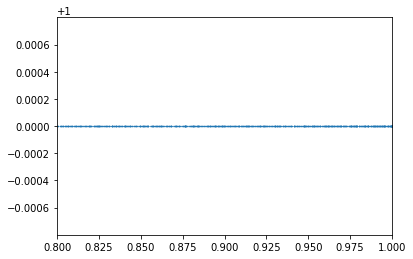

In [940]:
fig, axes = plt.subplots()
axes.scatter(df_scores['auc'] , df_scores['true_pos'], s=0.1 )
axes.set_xlim([0.8,1])
plt.show()

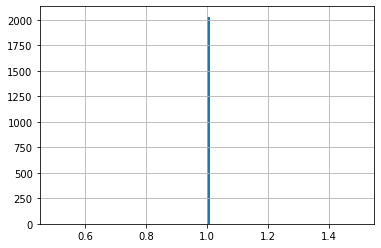

In [941]:
auc_domid_8['true_pos'].hist(bins=100)

In [950]:
auc_domid = pd.merge(left=df_scores, right=accession_domid, how='left', left_on='prot_name', right_on='accession')

In [952]:
auc_domid

threshold       auc                                               plot  \
0           0.5  0.726200  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
1           0.5  0.372112  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
2           0.5  0.490087  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
3           0.5  0.521383  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
4           0.5  0.991480  {0.0: 0.0, 0.01: 0.6451612903225806, 0.02: 1.0...   
...         ...       ...                                                ...   
6100        0.5  0.073734  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6101        0.5  0.029330  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6102        0.5  0.959692  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6103        0.5  0.443552  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6104        0.5  0.328855  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   

                                     pr_curve  true_pos  true_neg prot_name  \
0     {0.0: 0.0, 1.0: 0.00029219597641630976}       1.0      6103    Q96E11   
1      {0.0: 0.0, 1.0: 0.0002048894677131553}       1.0      6103    Q96C74   
2      {0.0: 0.0, 1.0: 0.0002251336695030285}       1.0      6103    P15018   
3     {0.0: 0.0, 1.0: 0.00023152026935305484}       1.0      6103    Q9BUD6   
4      {0.0: 0.0, 1.0: 0.0007858481821597959}       1.0      6103    O14957   
...                                       ...       ...       ...       ...   
6100  {0.0: 0.0, 1.0: 0.00017018044689157827}       1.0      6103    Q9BZI1   
6101  {0.0: 0.0, 1.0: 0.00016627727101745107}       1.0      6103    Q01970   
6102   {0.0: 0.0, 1.0: 0.0005478693760692219}       1.0      6103    Q9H5I1   
6103   {0.0: 0.0, 1.0: 0.0002164995243662692}       1.0      6103    Q8WY91   
6104  {0.0: 0.0, 1.0: 0.00019865201800908376}       1.0      6103    Q9HBR0   

      exp_median  exp_mean   exp_var  \
0       0.782593  0.707863  0.068525   
1       0.326831  0.321065  0.024241   
2       0.293733  0.290197  0.030773   
3       0.574965  0.530279  0.048892   
4       0.684997  0.627684  0.074148   
...          ...       ...       ...   
6100    0.190179  0.187417  0.010521   
6101    0.675224  0.600175  0.071309   
6102    0.692830  0.636992  0.076316   
6103    0.757734  0.685806  0.070514   
6104    0.722062  0.654573  0.066595   

                                   pdb_chain_domain  
0                                         [1wqgA01]  
1                                         [2izxB00]  
2                                         [1lkiA00]  
3                                         [1lslA01]  
4                                         [1ntmK00]  
...                                             ...  
6100                             [1b8iB00, 1jhnA02]  
6101  aiA00, 1qasA01, 1djxA02, 1djxA03, 1jadA00]  
6102                             [1q3lA00, 2f69A02]  
6103                                      [1s58A00]  
6104                             [1v54A00, 1s58A00]  

[6105 rows x 11 columns]

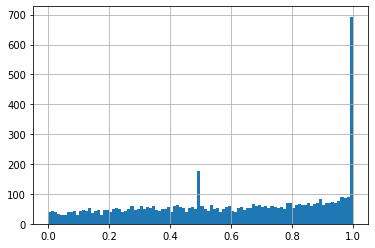

In [951]:
auc_domid['auc'].hist(bins=100)

In [925]:
auc_domid_8 = auc_domid[auc_domid['auc']>=0.8]
auc_domid_2 = auc_domid[auc_domid['auc']<=0.2]

In [927]:
prot = long_form_dom_2[long_form_dom_2['col_1']=='Q8WUP2']
prot = prot[prot["tm_score"] >= 0.0]

In [897]:
prot['no_of_pairs'] = [len(x) for x in prot['dom_pair_scores']]

In [928]:
prot = prot[prot['col_1'] != prot['col_2']]
prot[(prot["tm_score"] >= 0.99) & (prot["exp"] >= 0.99) ]

Empty DataFrame
Columns: [col_1, col_2, exp, pdb_chain_domain_x, pdb_chain_domain_y, dom_pairs, dom_pair_scores, tm_score]
Index: []

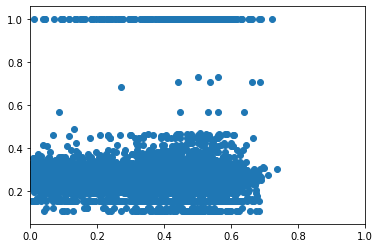

In [929]:
fig, axes = plt.subplots()
axes.scatter(prot['exp'] , prot['tm_score'])
axes.set_xlim([0.0,1])
plt.show()

KeyError: 'no_of_pairs'

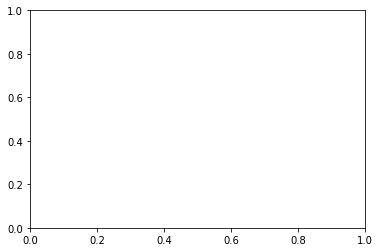

In [913]:
fig, axes = plt.subplots()
axes.scatter(prot['exp'] , prot['no_of_pairs'])
#axes.set_ylim([0.9,1])
plt.show()

In [934]:
auc_domid[auc_domid['prot_name']=='Q6JVE6']


threshold       auc                                               plot  \
26        0.5  0.910372  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   

                                  pr_curve  true_pos  true_neg prot_name  \
26  {0.0: 0.0, 1.0: 0.0004339425739670042}       1.0      6103    Q6JVE6   

    exp_median  exp_mean   exp_var pdb_chain_domain  
26    0.099976  0.124597  0.009468        [1xkiA00]

In [658]:
#auc_domid.sort_values(by=['auc'], ascending=False).head(20)
s = auc_domid.apply(lambda x: pd.Series(x['pdb_chain_domain']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'domain'


In [659]:
auc_ind_domid = auc_domid.drop('pdb_chain_domain', axis=1).join(s)

In [660]:
auc_domid_cath = pd.merge(left=auc_ind_domid, right=data, how='left', left_on='domain', right_on='pdb_chain_domain')

In [905]:
auc_ind_domid

threshold       auc                                           pr_curve  \
0           0.9  0.490087             {0.0: 0.0, 1.0: 0.0002251336695030285}   
1           0.9  0.376558  {0.0: 0.0, 0.05: 0.0009549619441794818, 0.09: ...   
2           0.9  0.263149            {0.0: 0.0, 1.0: 0.00019010859759952808}   
3           0.9  0.544436  {0.0: 0.0, 0.01: 0.007943449567068337, 0.02: 0...   
3           0.9  0.544436  {0.0: 0.0, 0.01: 0.007943449567068337, 0.02: 0...   
...         ...       ...                                                ...   
5560        0.9  0.805900  {0.0: 0.0, 0.14: 0.0028135445251216604, 0.29: ...   
5560        0.9  0.805900  {0.0: 0.0, 0.14: 0.0028135445251216604, 0.29: ...   
5561        0.9  0.502846  {0.0: 0.019685052194635774, 0.01: 0.0689096546...   
5562        0.9  0.512889  {0.0: 0.0559389972005364, 0.01: 0.115025195032...   
5562        0.9  0.512889  {0.0: 0.0559389972005364, 0.01: 0.115025195032...   

      true_pos  true_neg prot_name  exp_median  exp_mean  exp_var       0.0  \
0            1      6103    P15018         0.3  0.290197     0.03  0.000000   
1           22      6082    Q9BUD6         0.6  0.530279     0.05  0.000000   
2            1      6103    Q16619         0.4  0.425880     0.04  0.000000   
3          102      6002    Q9H1Q7         0.7  0.643078     0.06  0.000000   
3          102      6002    Q9H1Q7         0.7  0.643078     0.06  0.000000   
...        ...       ...       ...         ...       ...      ...       ...   
5560         7      6097    Q9H5I1         0.7  0.636992     0.08  0.000000   
5560         7      6097    Q9H5I1         0.7  0.636992     0.08  0.000000   
5561       888      5216    Q8WY91         0.8  0.685806     0.07  0.000000   
5562       889      5215    Q9HBR0         0.7  0.654573     0.07  0.000931   
5562       889      5215    Q9HBR0         0.7  0.654573     0.07  0.000931   

      ...      0.92      0.93      0.94      0.95      0.96      0.97  \
0     ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     ...  0.954545  0.954545  0.954545  0.954545  0.976540  1.000000   
2     ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3     ...  0.950980  0.950980  0.956445  0.972170  0.983607  0.990196   
3     ...  0.950980  0.950980  0.956445  0.972170  0.983607  0.990196   
...   ...       ...       ...       ...       ...       ...       ...   
5560  ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5560  ...  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5561  ...  0.946373  0.953205  0.962821  0.972499  0.980265  0.988567   
5562  ...  0.927311  0.937204  0.945212  0.955849  0.968416  0.979638   
5562  ...  0.927311  0.937204  0.945212  0.955849  0.968416  0.979638   

          0.98      0.99       1.0   domain  
0     1.000000  1.000000  1.000000  1lkiA00  
1     1.000000  1.000000  1.000000  1lslA01  
2     1.000000  1.000000  1.000000  1lkiA00  
3     0.990196  0.995661  1.000000  1es9A00  
3     0.990196  0.995661  1.000000  1jhnA02  
...        ...       ...       ...      ...  
5560  1.000000  1.000000  1.000000  1q3lA00  
5560  1.000000  1.000000  1.000000  2f69A02  
5561  0.994008  0.997392  1.000000  1s58A00  
5562  0.988639  0.997537  0.999116  1v54A00  
5562  0.988639  0.997537  0.999116  1s58A00  

[11506 rows x 111 columns]

In [661]:
g = auc_ind_domid.groupby(['domain']).agg({'auc': ['mean', 'count']})

In [662]:
g_cath = pd.merge(left=g, right=data, how='left', left_on='domain', right_on='pdb_chain_domain')

/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [663]:
g_cath

(auc, mean)  (auc, count) pdb_chain_domain version           cath  \
0        0.961330             1          1a0rP02  v4_2_0    1.10.168.10   
1        0.523859             1          1a1hA01  v4_2_0    3.30.160.60   
2        0.754913             2          1a1wA00  v4_2_0    1.10.533.10   
3        0.524358             2          1a3qA01  v4_2_0    2.60.40.340   
4        0.589382             1          1a4iA02  v4_2_0  3.40.50.10860   
...           ...           ...              ...     ...            ...   
2298     0.646551             1          3ygsP00  v4_2_0    1.10.533.10   
2299     0.573285            11          4dpvZ00  v4_2_0    2.170.30.10   
2300     0.523746            25          4mt2A00  v4_2_0     4.10.10.10   
2301     0.548509             1          6ldhA01  v4_2_0    3.40.50.720   
2302     0.474161             3          6ldhA02  v4_2_0    3.90.110.10   

       residues  
0       14-96:P  
1     103-132:A  
2        1-83:A  
3      37-221:A  
4      31-119:A  
...         ...  
2298     1-97:P  
2299   22-584:Z  
2300     1-61:A  
2301    1-162:A  
2302  163-329:A  

[2303 rows x 6 columns]

In [285]:
g_cath.columns

Index([   ('auc', 'mean'),   ('auc', 'count'), 'pdb_chain_domain',
                'version',             'cath',         'residues'],
      dtype='object')

In [292]:
g_cath.sort_values(by=[('auc', 'mean')], ascending=False)

(auc, mean)  (auc, count) pdb_chain_domain version          cath  \
418      1.000000             2          1gqvA00  v4_2_0   3.10.130.10   
2130     0.998771             2          2z7fI00  v4_2_0    4.10.75.10   
1929     0.998198             2          2nyzE00  v4_2_0    2.40.50.40   
876      0.996641             2          1n9rB00  v4_2_0   2.30.30.100   
571      0.995658             2          1j1dE00  v4_2_0    1.20.5.350   
...           ...           ...              ...     ...           ...   
1115     0.076192             2          1qsmD00  v4_2_0   3.40.630.30   
435      0.074062             2          1gxyA00  v4_2_0   3.90.176.10   
1595     0.058660             2          1zndA00  v4_2_0   2.40.128.20   
2020     0.039898             2          2ql2C00  v4_2_0   4.10.280.10   
2159     0.008684             2          3b9wA00  v4_2_0  1.10.3430.10   

       residues  
418     0-134:A  
2130   58-107:I  
1929     7-72:E  
876     18-86:B  
571   200-274:E  
...         ...  
1115    5-156:D  
435     4-226:A  
1595    1-157:A  
2020  543-602:C  
2159    8-369:A  

[2303 rows x 6 columns]

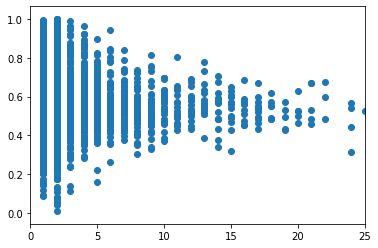

In [269]:
fig, axes = plt.subplots()
axes.scatter(g['auc']['count'] , g['auc']['mean'] )
axes.set_xlim([0,25])
plt.show()

In [ ]:
df_scores = df_scores[df_scores['threshold']==0.9]
df_score

In [36]:
df_scores['exp_median'] = df_scores['exp_median'].round(1)

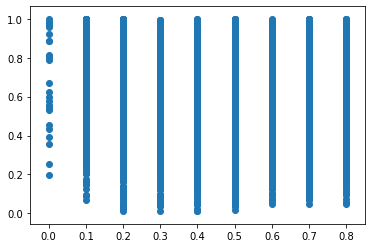

In [814]:
fig, axes = plt.subplots()
axes.scatter(df_scores['exp_median'] , df_scores['auc'] )
#axes.set_ylim([0,1])
plt.show()

In [646]:
df_scores['exp_var'] = df_scores['exp_var'].round(2)

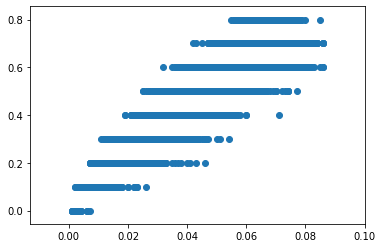

In [462]:
fig, axes = plt.subplots()
axes.scatter(df_scores['exp_var'] , df_scores['exp_median'] )
#axes.set_ylim([0,1])
plt.show()

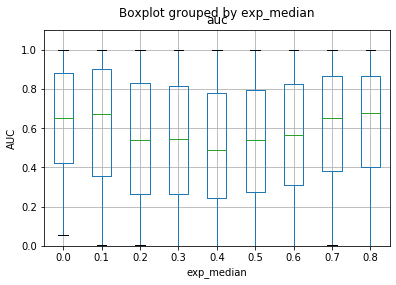

In [37]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='exp_median', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

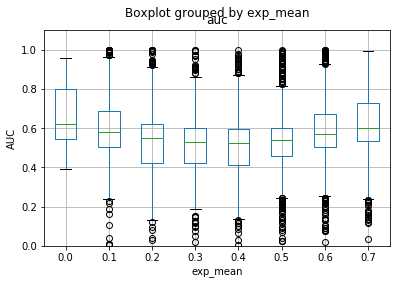

In [540]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='exp_mean', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

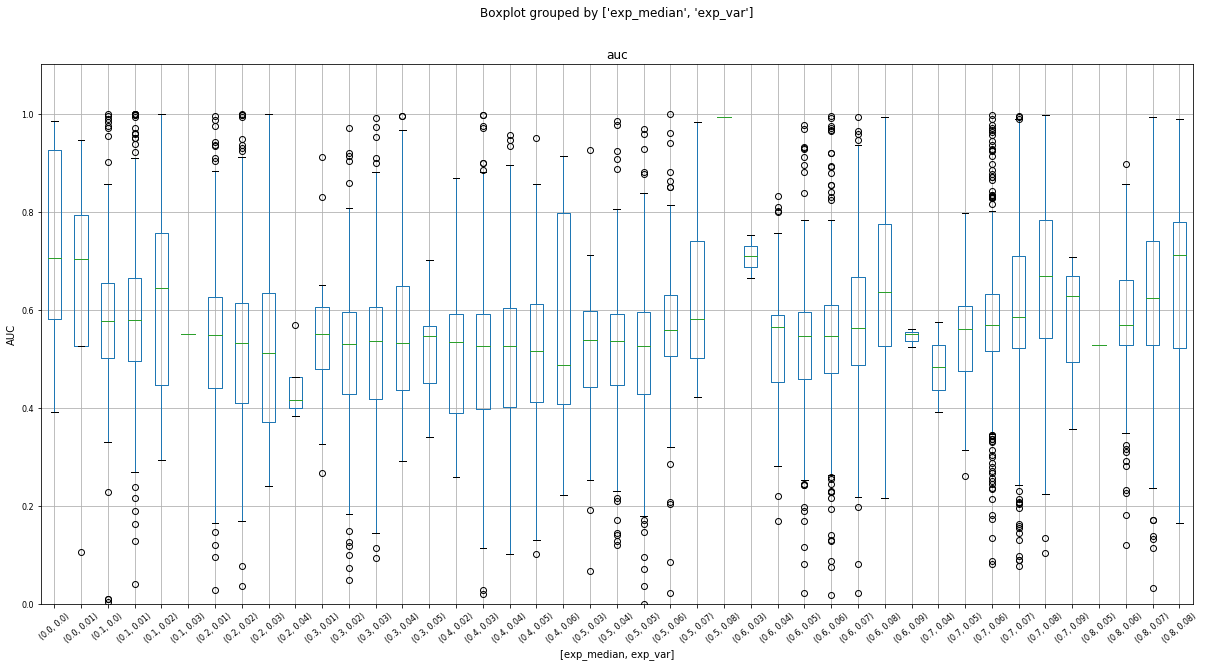

In [503]:
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by=[ 'exp_median', 'exp_var'], ax=axes,  rot=40, fontsize=8)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [26]:
df_scores = pd.DataFrame(m_l, columns =['threshold', 'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'prot_name', 'exp_median', 'exp_mean', 'exp_var', 'top_match_protein', 'dom_pair_a', 'dom_pair_b', 'real_tm_score'])
df_scores.dropna(inplace=True)

In [52]:
df_scores

threshold       auc                                               plot  \
0           0.9  0.406685  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
1           0.9  0.009340  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
2           0.9  0.997051  {0.0: 0.41935483870967744, 0.01: 1.0, 0.02: 1....   
3           0.9  0.500737  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
4           0.9  0.991152  {0.0: 0.0, 0.01: 0.6129032258064516, 0.02: 1.0...   
...         ...       ...                                                ...   
6100        0.9  0.779780  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6101        0.9  0.649517  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6102        0.9  0.893987  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6103        0.9  0.372931  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
6104        0.9  0.722104  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   

                                     pr_curve  true_pos  true_neg prot_name  \
0     {0.0: 0.0, 1.0: 0.00021028509762975784}       1.0      6103    Q13516   
1     {0.0: 0.0, 1.0: 0.00016459675624183335}       1.0      6103    Q9H9V4   
2       {0.0: 0.0, 1.0: 0.000952824362624425}       1.0      6103    Q9NXS2   
3     {0.0: 0.0, 1.0: 0.00022725044762354277}       1.0      6103    P49638   
4      {0.0: 0.0, 1.0: 0.0007799283893197124}       1.0      6103    Q96AY2   
...                                       ...       ...       ...       ...   
6100  {0.0: 0.0, 1.0: 0.00031785798014040103}       1.0      6103    Q96D21   
6101  {0.0: 0.0, 1.0: 0.00026442724823898885}       1.0      6103    Q9H0B6   
6102   {0.0: 0.0, 1.0: 0.0004111531228277536}       1.0      6103    Q8WXK1   
6103  {0.0: 0.0, 1.0: 0.00020501289145849922}       1.0      6103    Q9UBB4   
6104   {0.0: 0.0, 1.0: 0.0002904852281138079}       1.0      6103    Q9H8E8   

      exp_median  exp_mean   exp_var top_match_protein dom_pair_a dom_pair_b  \
0       0.111412  0.124889  0.006880            P41134    1mdyA00    1mdyA00   
1       0.536555  0.487274  0.053088            Q8TEB7    1iymA00    1iymA00   
2       0.680528  0.617230  0.064257            Q969V3    1tkjA00    1tkjA00   
3       0.144013  0.156029  0.011264            Q5SYC1    3b7nA01    3b7nA01   
4       0.576148  0.525540  0.057279            Q8IYD8    1j23A00    1j23A00   
...          ...       ...       ...               ...        ...        ...   
6100    0.287556  0.289559  0.023629            Q9Y272    2erxA00    2erxA00   
6101    0.685407  0.630453  0.062218            O76094    1na0A00    1na0A00   
6102    0.089215  0.110053  0.008259            Q8WXK4    1n0qB00    1n0qB00   
6103    0.766401  0.695336  0.073846            Q9NZ71    1u6gC00    1u6gC00   
6104    0.767257  0.696742  0.069914            O60502    1n71B00    2i79D00   

      real_tm_score  
0           1.00000  
1           1.00000  
2           1.00000  
3           1.00000  
4           1.00000  
...             ...  
6100        1.00000  
6101        1.00000  
6102        1.00000  
6103        1.00000  
6104        0.72832  

[6105 rows x 14 columns]

KeyError: 'para_dig'

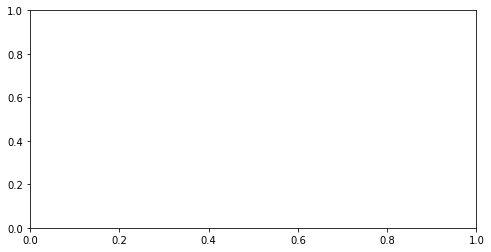

In [23]:
fig, axes = plt.subplots(figsize=(8,4))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by=['para_dig'], ax=axes,  rot=40, fontsize=8)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
axes.set_xlabel('Paralogue pair')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [624]:
df_scores[(df_scores['auc'] == 1) & (df_scores['para_dig'] == 1) ]['auc'].value_counts()

1.0    183
Name: auc, dtype: int64

In [717]:
df_scores = df_scores[df_scores['para_dig'] == 1 ]

In [722]:
df_scores = df_scores[df_scores['para_dig'] == 0 ]

In [33]:
df_scores = df_scores[df_scores['exp_median'] < 0.3]

In [667]:
df_scores = df_scores[(df_scores['exp_median'] > 0.3) & (df_scores['exp_median'] < 0.7)]

In [707]:
df_scores = auc_domid_8

In [29]:
df_scores = pd.concat([df_scores.drop(['plot'], axis=1), df_scores['plot'].apply(pd.Series)], axis=1)

In [30]:
df_plot = df_scores.groupby(['threshold']).mean()

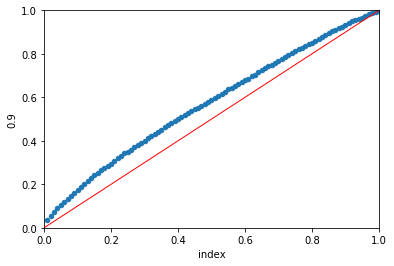

In [31]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[8::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

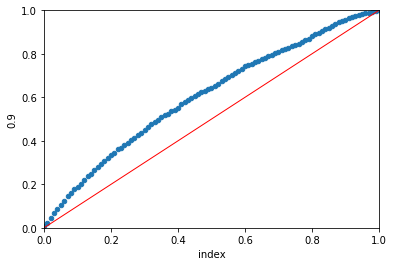

In [804]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[8::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

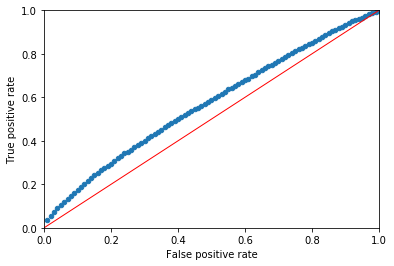

In [32]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[8::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('When median co-expression is <0.3')
    #axes.set_title('Randomly picked first true positive')
    #axes.yaxis.grid(True)
    axes.set_xlabel('False positive rate')
    axes.set_ylabel('True positive rate')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

In [45]:
df_scores[df_scores.auc == df_scores.auc.max()].sample()
df_scores.at[3148, 'threshold'] = 10

In [46]:
df_scores.at[3148, 'threshold'] = 10

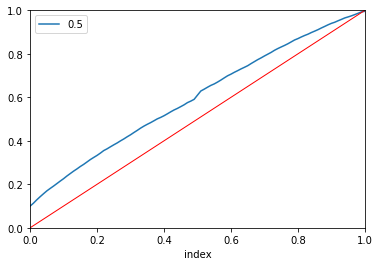

In [946]:
#fig, axes = plt.subplots(1,1, sharex=True, sharey=True)
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[6::].plot(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

In [301]:
df_plot

threshold                                       0.5
auc                                         0.98001
pr_curve     {0.0: 0.0, 1.0: 0.0006534048274245737}
true_pos                                          1
true_neg                                       6103
                              ...                  
0.96                                              1
0.97                                              1
0.98                                              1
0.99                                              1
1.0                                               1
Name: 3, Length: 114, dtype: object

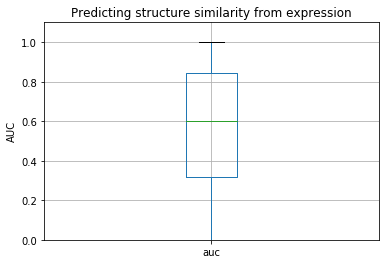

In [35]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'],ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

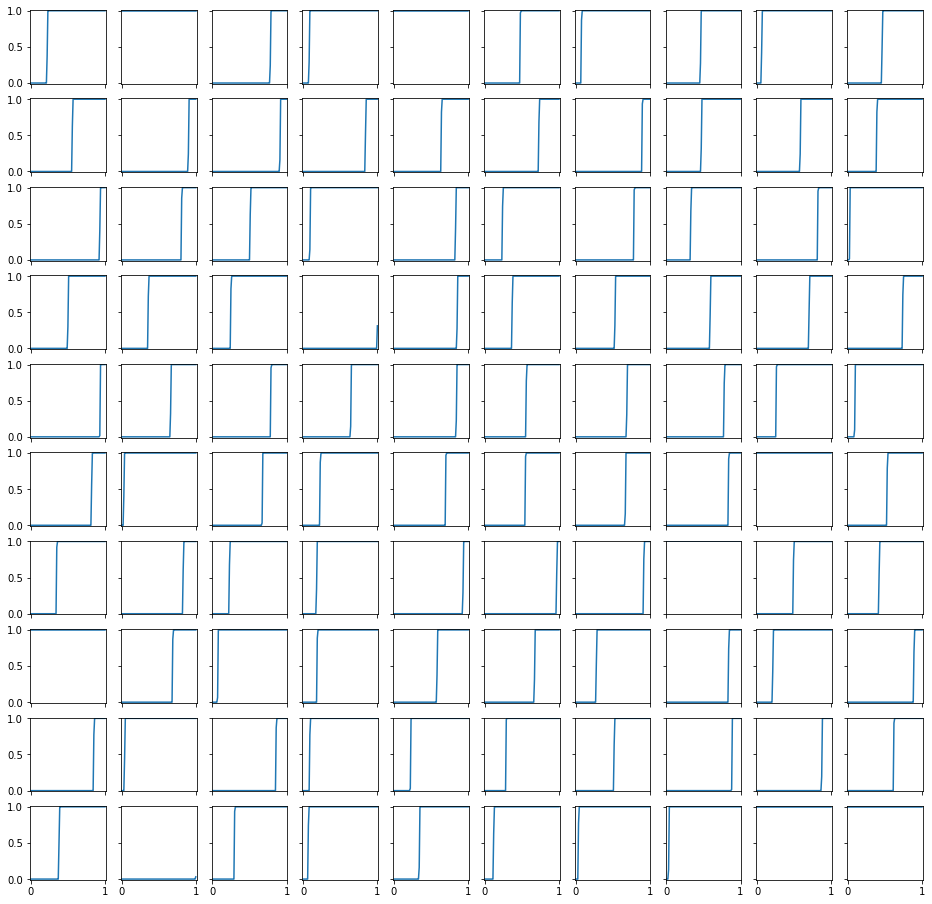

In [315]:
fig, axes = plt.subplots(10,10, sharex=True, sharey=True)
for thresh, ax  in zip(range(0,100), axes.flatten()): 
    
    df_plot = df_scores.iloc[thresh]
    #df_plot = df_scores.iloc[thresh]
    ax.plot(*zip(*sorted(df_plot['plot'].items())))
    #if (df_plot['prot_name'] == 'Q8WUP2'):
    #ax.plot(*zip(*sorted(df_scores['plot'].items())))
    #df_plot = pd.concat([df_plot.drop(['plot'], axis=1), df_plot['plot'].apply(pd.Series)], axis=1)
    #ax = df_plot.T.reset_index().plot(x='index', y=thresh)
    #ax.plot([0, 1], [0, 1], 'red', linewidth=1)
        #ax = df_plot.T.reset_index().plot(x='index', y=0.3)
        #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
        #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
        #axes.set_title('Predicting structure similarity from expression')
        #axes.yaxis.grid(True)
        #axes.set_xlabel('Co-expression')
        #axes.set_ylabel('AUC')
        #axes.set_ylim([0.0,1.101])
        #plt.setp(bp['fliers'], markersize=3.0)
        #0.5
        #fig, axes = plt.subplots()
        #axes.scatter(x, y)
        #axes.plot(x, y)
        #break
ax.set_ylim([-0.01,1.01])
ax.set_xlim([-0.01,1.01])
fig.set_size_inches(16,16)
#plt.show()
plt.show()

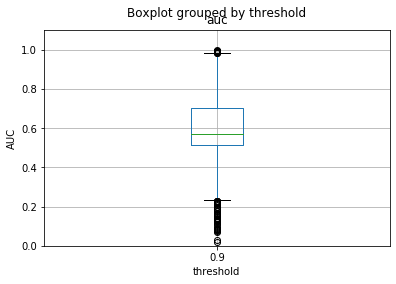

In [184]:
fig, axes = plt.subplots()
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
bp = df_scores.boxplot(column=['auc'], by='threshold', ax=axes)
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [125]:
pwd

'/data/lohia/EGAD_analysis/egad_cath'

In [126]:
uid_protname_db.to_csv("/data/lohia/EGAD_analysis/egad_cath/protein_auc", index=False)


threshold  auc                                               plot  \
2           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
3           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
4           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
6           0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
...         ...  ...                                                ...   
5598        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5712        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5771        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5891        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   
5909        0.5  1.0  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....   

                        pr_curve  true_pos  true_neg prot_name  exp_median  \
2     {1.0: 0.00152260765876942}       1.0      6103    P17509    0.170735   
3     {1.0: 0.00152260765876942}       1.0      6103    P31273    0.085531   
4     {1.0: 0.00152260765876942}       1.0      6103    P09067    0.108086   
5     {1.0: 0.00152260765876942}       1.0      6103    P09629    0.414260   
6     {1.0: 0.00152260765876942}       1.0      6103    P09630    0.103786   
...                          ...       ...       ...       ...         ...   
5598  {1.0: 0.00152260765876942}       1.0      6103    P27169    0.149954   
5712  {1.0: 0.00152260765876942}       1.0      6103    Q13823    0.749797   
5771  {1.0: 0.00152260765876942}       1.0      6103    Q9NR12    0.476361   
5891  {1.0: 0.00152260765876942}       1.0      6103    Q96NU0    0.215091   
5909  {1.0: 0.00152260765876942}       1.0      6103    P35612    0.520241   

      exp_mean   exp_var  ...        cath_x   residues_x pdb_chain_domain_y  \
2     0.172980  0.009705  ...    1.10.10.60     88-160:A            1b8iA00   
3     0.090403  0.002681  ...    1.10.10.60     88-160:A            1b8iA00   
4     0.115854  0.004691  ...    1.10.10.60     88-160:A            1b8iA00   
5     0.384499  0.032055  ...    1.10.10.60     88-160:A            1b8iA00   
6     0.112479  0.004651  ...    1.10.10.60     88-160:A            1b8iA00   
...        ...       ...  ...           ...          ...                ...   
5598  0.164560  0.011374  ...   2.120.10.30     16-355:A            1v04A00   
5712  0.678995  0.074410  ...   3.40.50.300     12-179:A            1pujA01   
5771  0.463833  0.056655  ...   2.10.110.10       1-66:A            1nypA00   
5891  0.224673  0.017884  ...  2.60.120.200  2695-2870:A            2jd4A02   
5909  0.483304  0.039663  ...   3.40.225.10      1-206:P            1k0wA00   

     version_y        cath_y   residues_y Entry_x  \
2       v4_2_0    1.10.10.60     88-160:A  P17509   
3       v4_2_0    1.10.10.60     88-160:A  P31273   
4       v4_2_0    1.10.10.60     88-160:A  P09067   
5       v4_2_0    1.10.10.60     88-160:A  P09629   
6       v4_2_0    1.10.10.60     88-160:A  P09630   
...        ...           ...          ...     ...   
5598    v4_2_0   2.120.10.30     16-355:A  P27169   
5712    v4_2_0   3.40.50.300     12-179:A  Q13823   
5771    v4_2_0   2.10.110.10       1-66:A  Q9NR12   
5891    v4_2_0  2.60.120.200  2695-2870:A  Q96NU0   
5909    v4_2_0   3.40.225.10      1-223:A  P35612   

                                        Protein names_x Entry_y  \
2     Homeobox protein Hox-B6 (Homeobox protein Hox-...  P31269   
3     Homeobox protein Hox-C8 (Homeobox protein Hox-3A)  P31269   
4     Homeobox protein Hox-B5 (Homeobox protein HHO....  P17483   
5     Homeobox protein Hox-B7 (Homeobox protein HHO....  P17483   
6     Homeobox protein Hox-C6 (Homeobox protein CP25...  P09629   
...                                                 ...     ...   
5598  Serum paraoxonase/arylesterase 1 (PON 1) (EC 3...  Q15166   
5712  Nucleolar GTP-binding protein 2 (Autoant

In [47]:
uid_protname_db_1 = df_scores[df_scores['auc'] == 1]

In [48]:
uid_protname_db_1

threshold  auc                    pr_curve  true_pos  true_neg  \
48          0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
326         0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
472         0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
603         0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
627         0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
663         0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
902         0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
1213        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
1652        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2114        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2434        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
2638        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3048        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3105        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3543        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3681        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3685        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3866        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3875        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
3878        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
4007        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
4406        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
4626        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
4666        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
4699        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
5322        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
5363        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
5370        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
5461        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
5475        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
5802        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   
5812        0.9  1.0  {1.0: 0.00152260765876942}       1.0      6103   

     prot_name  exp_median  exp_mean   exp_var top_match_protein  ... 0.91  \
48      P09488    0.095065  0.109600  0.007983            P28161  ...  1.0   
326     P19429    0.080303  0.102784  0.007273            P13805  ...  1.0   
472     Q2VIR3    0.493042  0.462351  0.059053            P41091  ...  1.0   
603     P29728    0.533924  0.481524  0.051614            Q9Y6K5  ...  1.0   
627     Q99879    0.104365  0.122788  0.010541            Q99880  ...  1.0   
663     P08579    0.703146  0.635018  0.080556            Q9Y3B4  ...  1.0   
902     Q86W10    0.159058  0.166536  0.009118            Q8N118  ...  1.0   
1213    P26599    0.751284  0.662523  0.071174            Q99729  ...  1.0   
1652    O43175    0.515099  0.475074  0.052425            Q9UBQ7  ...  1.0   
2114    Q86UP8    0.651840  0.591179  0.054519            Q6EKJ0  ...  1.0   
2434    P10153    0.201924  0.220043  0.028794            P12724  ...  1.0   
2638    P31994    0.448013  0.403137  0.040170            P12318  ...  1.0   
3048    P05109    0.160091  0.205600  0.035653            P06702  ...  1.0   
3105    P12724    0.129384  0.146813  0.012086            P10153  ...  1.0   
3543    P27169    0.149954  0.164560  0.011374            Q15166  ...  1.0   
3681    P09238    0.050549  0.070719  0.004554            P08254  ...  1.0   
3685    O14879    0.439027  0.412175  0.049082            P09913  ...  1.0   
3866    P01583    0.128079  0.150967  0.013791            P01584  ...  1.0   
3875    P13500    0.286798  0.291904  0.037706            P80075  ...  1.0   
3878    P09629    0.414260  0.384499  0.032055            P17483  ...

In [49]:
uid_protname_db_1['Protein names_y'].value_counts() 

KeyError: 'Protein names_y'

In [50]:
uid_protname_db_1['dom_pair_b'].value_counts().to_string()

'1px5A01    2\n1gqvA00    2\n2c4jA02    2\n1po5A00    2\n2ra4A00    2\n1j1dE00    1\n1na0A00    1\n1k0wA00    1\n1v04A00    1\n2g76A01    1\n1oiaB00    1\n2h26A01    1\n1tzyF00    1\n1jvrA00    1\n1q60A00    1\n1yceA01    1\n1tvkA02    1\n1kjzA03    1\n1b8iA00    1\n1xk4D00    1\n2fcbA01    1\n1l2hA00    1\n1n9rB00    1\n2z7fI00    1\n2dgsA01    1\n1t8tA00    1\n1slmA00    1'

In [129]:
uid_protname_db_1.groupby(['Protein names_y']).count()

threshold  auc  plot  \
Protein names_y                                                            
(E2-independent) E3 ubiquitin-conjugating enzym...          1    1     1   
2'-5'-oligoadenylate synthase 3 ((2-5')oligo(A)...          1    1     1   
A-kinase anchor protein 8 (AKAP-8) (A-kinase an...          1    1     1   
AF4/FMR2 family member 4 (ALL1-fused gene from ...          1    1     1   
AT-rich interactive domain-containing protein 5...          1    1     1   
...                                                       ...  ...   ...   
Zinc finger protein 804A                                    1    1     1   
Zinc finger protein 839 (Renal carcinoma antige...          1    1     1   
Zinc finger protein GLI2 (GLI family zinc finge...          1    1     1   
mRNA-decapping enzyme 1A (EC 3.-.-.-) (Smad4-in...          1    1     1   
p53-induced death domain-containing protein 1 (...          1    1     1   

                                                    pr_curve  true_pos  \
Protein names_y                                                          
(E2-independent) E3 ubiquitin-conjugating enzym...         1         1   
2'-5'-oligoadenylate synthase 3 ((2-5')oligo(A)...         1         1   
A-kinase anchor protein 8 (AKAP-8) (A-kinase an...         1         1   
AF4/FMR2 family member 4 (ALL1-fused gene from ...         1         1   
AT-rich interactive domain-containing protein 5...         1         1   
...                                                      ...       ...   
Zinc finger protein 804A                                   1         1   
Zinc finger protein 839 (Renal carcinoma antige...         1         1   
Zinc finger protein GLI2 (GLI family zinc finge...         1         1   
mRNA-decapping enzyme 1A (EC 3.-.-.-) (Smad4-in...         1         1   
p53-induced death domain-containing protein 1 (...         1         1   

                                                    true_neg  prot_name  \
Protein names_y                                                           
(E2-independent) E3 ubiquitin-conjugating enzym...         1          1   
2'-5'-oligoadenylate synthase 3 ((2-5')oligo(A)...         1          1   
A-kinase anchor protein 8 (AKAP-8) (A-kinase an...         1          1   
AF4/FMR2 family member 4 (ALL1-fused gene from ...         1          1   
AT-rich interactive domain-containing protein 5...         1          1   
...                                                      ...        ...   
Zinc finger protein 804A                                   1          1   
Zinc finger protein 839 (Renal carcinoma antige...         1          1   
Zinc finger protein GLI2 (GLI family zinc finge...         1          1   
mRNA-decapping enzyme 1A (EC 3.-.-.-) (Smad4-in...         1          1   
p53-induced death domain-containing protein 1 (...         1          1   

                                                    exp_median  exp_mean  \
Protein names_y                                                            
(E2-independent) E3 ubiquitin-conjugating enzym...           1         1   
2'-5'-oligoadenylate synthase 3 ((2-5')oligo(A)...           1         1   
A-kinase anchor protein 8 (AKAP-8) (A-kinase an...           1         1   
AF4/FMR2 family member 4 (ALL1-fused gene from ...           1         1   
AT-rich interactive domain-containing protein 5...           1         1   
...                                                        ...       ...   
Zinc finger protein 804A                                     1         1   
Zinc finger protein 839 (Renal carcinoma antige...           1         1   
Zinc finger protein GLI2 (GLI family zinc finge...           1         1   
mRNA-decapping enzyme 1A (EC 3.-.-.-) (Smad4-in...           1         1   
p53-induced death domain-containing protein 1 (...           1         1   

                                                    exp_var  ...  version_x  \
Protein names_y                                         